In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
splitfolders.ratio("/content/drive/MyDrive/dataset/rice_plant_lacks_nutrients", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False) # default values

Copying files: 1135 files [01:18, 14.41 files/s]


In [ ]:
data_dir = pathlib.Path('/content/output/train')
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

In [ ]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['Nitrogen(N)' 'Phosphorus(P)' 'Potassium(K)']


In [ ]:
# Show total data in folder
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
3 folder and 0 images in output/train
0 folder and 330 images in output/train/Nitrogen(N)
0 folder and 270 images in output/train/Potassium(K)
0 folder and 250 images in output/train/Phosphorus(P)
3 folder and 0 images in output/val
0 folder and 88 images in output/val/Nitrogen(N)
0 folder and 72 images in output/val/Potassium(K)
0 folder and 66 images in output/val/Phosphorus(P)
3 folder and 0 images in output/test
0 folder and 22 images in output/test/Nitrogen(N)
0 folder and 19 images in output/test/Potassium(K)
0 folder and 18 images in output/test/Phosphorus(P)


In [ ]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])

    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (3901, 323, 3)


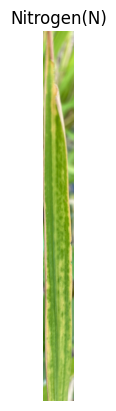

Image Shape : (4025, 269, 3)


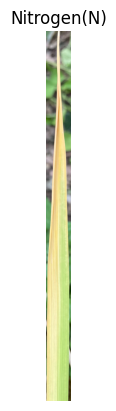

Image Shape : (4026, 229, 3)


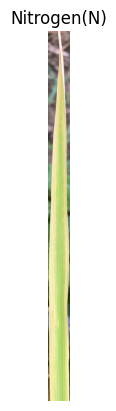

Image Shape : (3976, 341, 3)


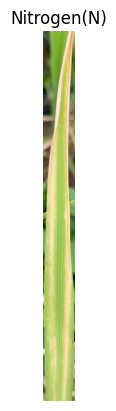

Image Shape : (225, 3472, 3)


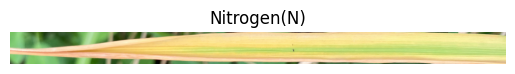

Image Shape : (302, 4018, 3)


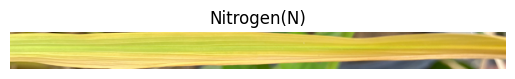

Image Shape : (388, 3930, 3)


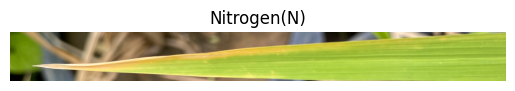

Image Shape : (4026, 247, 3)


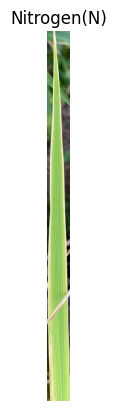

Image Shape : (3222, 268, 3)


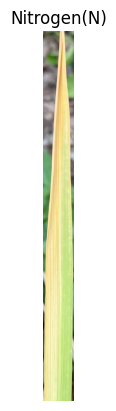

In [ ]:
for i in range(1,10):
    img_n = view_random_image(target_dir='/content/output/train/', target_class='Nitrogen(N)')

In [ ]:
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 850 images belonging to 3 classes.
Found 226 images belonging to 3 classes.
Found 59 images belonging to 3 classes.


In [ ]:
train_data.class_indices

{'Nitrogen(N)': 0, 'Phosphorus(P)': 1, 'Potassium(K)': 2}

In [ ]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [ ]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (850,)
val_y.shape:  (226,)
test_y.shape:  (59,)


In [ ]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Model Preparation
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [ ]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                             

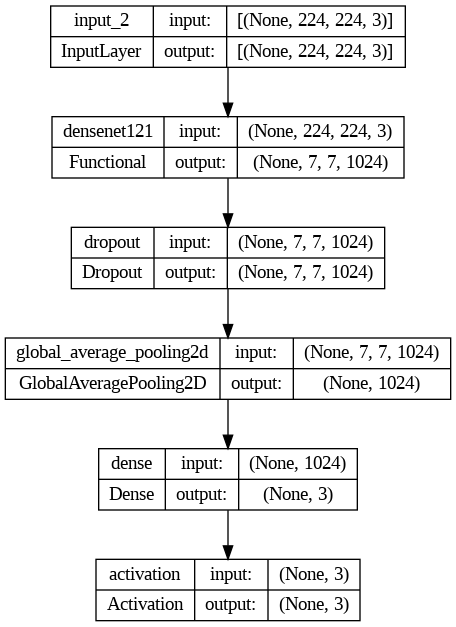

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=15, validation_data=valid_data)

Epoch 1/15
54/54 [==============================] - 219s 4s/step - loss: 0.9231 - accuracy: 0.5753 - val_loss: 0.6883 - val_accuracy: 0.6947
Epoch 2/15
54/54 [==============================] - 264s 5s/step - loss: 0.5946 - accuracy: 0.7871 - val_loss: 0.4891 - val_accuracy: 0.8496
Epoch 3/15
54/54 [==============================] - 196s 4s/step - loss: 0.4884 - accuracy: 0.8412 - val_loss: 0.4012 - val_accuracy: 0.8628
Epoch 4/15
54/54 [==============================] - 194s 4s/step - loss: 0.4096 - accuracy: 0.8553 - val_loss: 0.3384 - val_accuracy: 0.8850
Epoch 5/15
54/54 [==============================] - 208s 4s/step - loss: 0.3777 - accuracy: 0.8682 - val_loss: 0.3156 - val_accuracy: 0.8894
Epoch 6/15
54/54 [==============================] - 193s 4s/step - loss: 0.3499 - accuracy: 0.8741 - val_loss: 0.2857 - val_accuracy: 0.9071
Epoch 7/15
54/54 [==============================] - 194s 4s/step - loss: 0.3181 - accuracy: 0.8776 - val_loss: 0.2713 - val_accuracy: 0.8894
Epoch 8/15
54

In [ ]:
# Function for showing plot of model
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()
# Show the plot of model

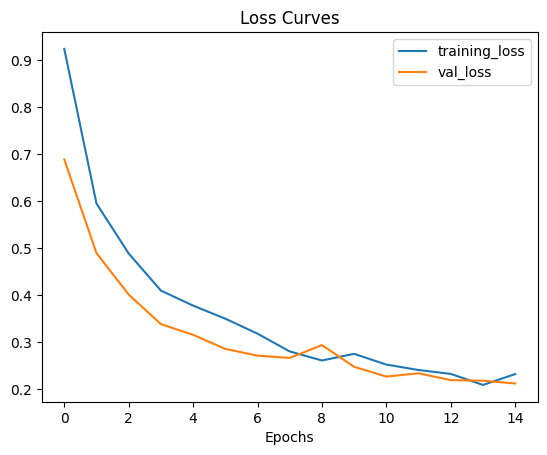

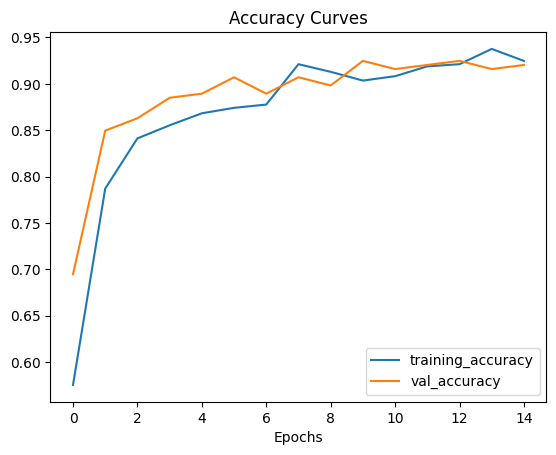

In [ ]:
# Show the plot of model
plot_loss_curves(history)

In [ ]:
# classification report
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

15/15 [==============================] - 44s 3s/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        85
           1       0.89      0.91      0.90        65
           2       0.93      0.88      0.91        76

    accuracy                           0.92       226
   macro avg       0.92      0.92      0.92       226
weighted avg       0.92      0.92      0.92       226



In [ ]:
# classification report
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

15/15 [==============================] - 37s 2s/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        85
           1       0.89      0.91      0.90        65
           2       0.93      0.88      0.91        76

    accuracy                           0.92       226
   macro avg       0.92      0.92      0.92       226
weighted avg       0.92      0.92      0.92       226



In [ ]:
# classification report
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

4/4 [==============================] - 11s 2s/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       0.94      0.94      0.94        18
           2       1.00      0.90      0.95        21

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59



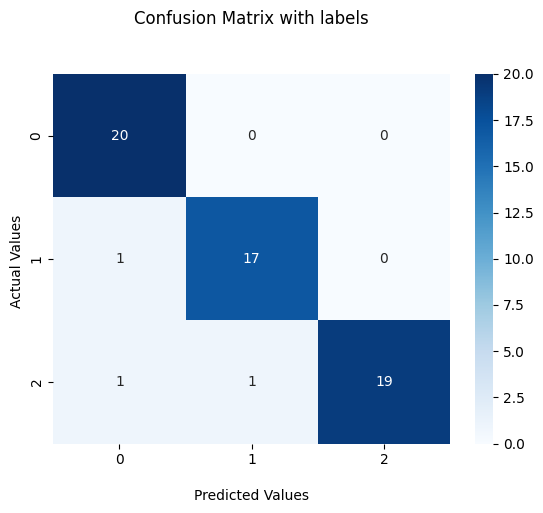

In [ ]:
# confusion matrix
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True,
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/rice_plant_model.h5')


In [ ]:
test_image=mpimg.imread('/content/drive/MyDrive/dataset/rice_plant_lacks_nutrients/Nitrogen(N)/untitled-1.JPG')

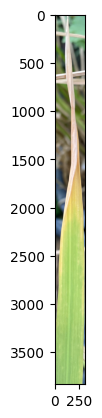

In [ ]:
imgplot = plt.imshow(test_image)

In [ ]:
img = tf.expand_dims(test_image,0) # need this to make batch_shape = 1
img=img/255  # normalizing the image
img=tf.image.resize(img,size=(224, 224))

In [ ]:
Prob=model.predict(img) # prediction

1/1 [==============================] - 4s 4s/step


0
Nitrogen(N)


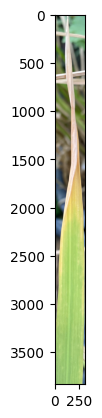

In [ ]:
indd=tf.argmax(Prob[0],axis=-1).numpy()
print(tf.argmax(Prob[0],axis=-1).numpy())
print(class_name[indd])
imgplot = plt.imshow(test_image)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y, test_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9491525423728814


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_y, test_pred))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.94      0.94      0.94        18
           2       0.90      1.00      0.95        19

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59



In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/RicePlant_NutrientDeficiency.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

In [2]:
!pip3 install tensorflow-serving-api==2.8.0

In [3]:
import cv2
import numpy as np
from keras.models import load_model
from keras.preprocessing import image

In [4]:
# Load your pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/RicePlant_NutrientDeficiency.h5')  # Replace with the correct path


In [5]:
def predict_label(img_path, model, dic):
    i = image.load_img(img_path, target_size=(224, 224))
    i = image.img_to_array(i) / 255.0
    i = i.reshape(1, 224, 224, 3)
    p = model.predict_classes(i)
    return dic[p[0]]

In [6]:
!pip install flask
!pip install pyngrok

In [7]:
!ngrok http 80

http - start an HTTP tunnel

USAGE:
  ngrok http [address:port | port] [flags]

AUTHOR:
  ngrok - <support@ngrok.com>

COMMANDS: 
  config          update or migrate ngrok's configuration file
  http            start an HTTP tunnel
  tcp             start a TCP tunnel
  tunnel          start a tunnel for use with a tunnel-group backend

EXAMPLES: 
  ngrok http 80                                                 # secure public URL for port 80 web server
  ngrok http --domain baz.ngrok.dev 8080                        # port 8080 available at baz.ngrok.dev
  ngrok tcp 22                                                  # tunnel arbitrary TCP traffic to port 22
  ngrok http 80 --oauth=google --oauth-allow-email=foo@foo.com  # secure your app with oauth

Paid Features: 
  ngrok http 80 --domain mydomain.com                           # run ngrok with your own custom domain
  ngrok http 80 --allow-cidr 2600:8c00::a03c:91ee:fe69:9695/32  # run ngrok with IP policy restrictions
  Upgrade your a

In [ ]:
import getpass
import os
import threading
from pyngrok import ngrok, conf
from flask import Flask, render_template_string, request
import cv2
import numpy as np
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
import base64

print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()

app = Flask(__name__)

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(5000).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}/\"".format(public_url, 5000))

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# Define label mapping
label_mapping = {
    0: 'NITROGEN',
    1: 'PHOSPHORUS',
    2: 'POTASSIUM'
}

# Define Flask routes
@app.route("/", methods=['GET', 'POST'])
def predict():
    prediction_result = None
    selected_image = None
    if request.method == 'POST':
        file = request.files['file']
        if file:
            image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)
            image = cv2.resize(image, (224, 224))
            num_parts = 5
            new_width = 224
            new_height = 224
            image_parts = []
            for i in range(0, image.shape[1], new_width):
                for j in range(0, image.shape[0], new_height):
                    image_parts.append(image[j:j+new_height, i:i+new_width])

            # Convert the list of image parts to a NumPy array
            image_parts = np.array(image_parts)

            # Normalize pixel values
            image_parts = image_parts.astype('float32') / 255

            # Reshape the image parts array to match the input shape expected by the model
            image_parts = image_parts.reshape((-1, 224, 224, 3))

            modellist = request.form['modellist']
            if modellist == "Rice":
                predictions = model.predict(image_parts)
                indd = np.argmax(predictions[0], axis=-1)
                prediction_result = f"Predicted Nutrient Deficiency: {label_mapping[indd]}"

            # Convert the selected image to base64 encoding
            _, buffer = cv2.imencode('.jpg', image)
            image_encoded = base64.b64encode(buffer).decode('utf-8')
            selected_image = f"data:image/jpeg;base64,{image_encoded}"

    return render_template_string('''
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Rice Plant Nutrient Deficiency Prediction</title>
            <style>
                h1 {
                    background-color: green;
                }
                body {
                    display: flex;
                    justify-content: center;
                    align-items: center;
                    background-color: green;
                    height: 100vh; /* Set height to viewport height for vertical centering */
                    margin: 0; /* Remove default margin */
                    padding: 0; /* Remove default padding */
                }
                .content {
                    text-align: center;
                }
            </style>
        </head>
        <body>
            <h1>Rice Plant Nutrient Deficiency Prediction</h1>
            <form method="post" enctype="multipart/form-data">
                <input type="file" name="file" accept="image/*"><br><br>
                <label for="modellist">Type of Image:</label>
                <select id="modellist" name="modellist">
                    <option value="Rice">Rice</option>
                    <!-- Add other options as needed -->
                </select><br><br>
                <input type="submit" value="Upload">
            </form>
            {% if selected_image %}
            <h2>Selected Image</h2>
            <img src="{{ selected_image }}" alt="Selected Image">
            {% endif %}
            {% if prediction_result %}
            <h2>Prediction Result</h2>
            <p>{{ prediction_result }}</p>
            {% endif %}
        </body>
        </html>
    ''', prediction_result=prediction_result, selected_image=selected_image)

if __name__ == '__main__':
    app.run()


Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
 * ngrok tunnel "https://669e-34-28-248-156.ngrok-free.app" -> "http://127.0.0.1:5000/"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:23:18] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:23:19] "GET /favicon.ico HTTP/1.1" 404 -
<ipython-input-8-1ac0b4853886>:39: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)


1/1 [==============================] - 3s 3s/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:23:51] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 168ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:25:04] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 160ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:28:19] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 152ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:28:33] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 170ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:30:52] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 158ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 03:42:47] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 383ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 04:14:21] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 169ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 04:41:00] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 213ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 04:41:10] "POST / HTTP/1.1" 200 -


1/1 [==============================] - 0s 273ms/step


INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 04:41:21] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 04:41:22] "POST / HTTP/1.1" 200 -


In [ ]:
!killall ngrok